In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pylab as pl
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from os import listdir
from os.path import isfile, join
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
import warnings
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
%matplotlib inline

from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr   
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Path is hardcoded. Just change the path below

In [2]:
import glob

path = r'/home/joncauchi/Desktop/DataScience/PART 1/data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

Given all our files have the same structure, we can merge them together.

## Data Cleaning

In [3]:
df.Airline = df.Airline.str.replace(' ', '')
df.Duration = df.Duration.str.replace(' ', '')
df.Airline = df.Airline.str.replace('\n', '')
df.Duration = df.Duration.str.replace('\n', '')
df.Duration = df.Duration.str.replace('m', '')
df.Duration = df.Duration.str.replace('h', '')
df.Price = df.Price.str.replace('€', '')
df.fillna(40, inplace=True)
df['Price'] = (df['Price']).astype(int)
df['Duration'] = (df['Duration']).astype(int)

Given our project only involves analysis of direct flights, we will remove flight instances of duration larger than 40 minutes. To do this, we converted the column 'Duration' from type str to int.

Removing undirect flights by neglecting flights longer than 40 mins

In [4]:
df['Date'] =pd.to_datetime(df.Date)
df = df.sort_values(by='Date')

In [5]:
df = df[df.Duration <= 40]

In [6]:
df_airline = df.groupby('Airline') 

Now we will split the dataframe into 3 different dataframes, one for each airline involved.

In [7]:
df_airmalta = df_airline.get_group('AirMalta') 
df_alitalia = df_airline.get_group('Alitalia') 
df_airitaly = df_airline.get_group('AirItaly') 

Now, for most days we have 2 instances of the same airline. These are 2 different routes and the routes are distinguished from the different departure time. Lets identify them and seperate them.

In [8]:
df_airmalta = df_airmalta.reset_index(drop = True)
df_alitalia = df_alitalia.reset_index(drop = True)
df_airitaly = df_airitaly.reset_index(drop = True)

So the structure of our dataset is as follows:
- Airline: For our dataset we have 3 airlines involved, each providing a direct route from Malta Luqa to Catania Fontanarossa
- Arrival Time: The time at which the route ends at Catania Fontanarossa
- Date: Date of flight
- Depart Time: The time at which the route starts by departing Malta Luqa AIrport
- Price: Cost of an economy class seat in Euro currency
- Route: Route ID of a flight

In [9]:
df.describe()

,Duration,Price
count,195.0,195.000000
mean,40.0,159.789744
std,0.0,97.339834
min,40.0,44.000000
25%,40.0,92.000000
50%,40.0,115.000000
75%,40.0,215.000000
max,40.0,486.000000


In [10]:
df.min()

Airline                   AirItaly
ArrivalTime                  05:40
Date           2019-12-04 00:00:00
DepartTime                   05:00
Duration                        40
Price                           44
dtype: object

In [11]:
df.max()

Airline                   Alitalia
ArrivalTime                  22:55
Date           2020-01-11 00:00:00
DepartTime                   22:15
Duration                        40
Price                          486
dtype: object

## There are 3 different departure times for all 3 airlines, 05:00 belongs to a particular route & 20:50 and 22:15 belongs to another route. It is also to note that there are never 20:50 and 22:15 flights on the same day as this is the same route.

Regarding the missing data, imputation is widely used to handle missing data. We would obtain good estimates of a statistical analysis such as Pearson correlation using  mean imputation. However, to estimate standard errors we will have to use multiple imputation. Omitting incomplete pairs is called a complete case analysis, and while inefficient, can work decently well. One must assume that the nature of the missingness doesn't depend on unmeasured values, like the outcome itself, for these approaches to be valid. In our case, there will be no imputation of missing data, we will work with what we have.

We have 2 routes for every airline. It is notable that the two routes provided by an airline are almost identical, same airline, same duration. The timing and price is different but it is to be noted that albeit provided by the same airline, lastng the same duration and departing on the same date, the prices of morning and evening flights can differ greatly. We will eventually compare and visualize the different routes for each particular airline

Now it would have been simpler to extract the route ID's from the website and group the data by route but due to difficulties met when attempting to extract the data, it has been decided that the routes will be assigned manually with a few lines of code.

After a quick search on the website, it is concluded that the following are the Route ID's of the recorded flights:
- Air Malta:
   - 05:00 = KM640
   - 20:50/22:15 = KM642
- Alitalia:
   - 05:00 = AZ7919
   - 20:50/22:15 = AZ7921
- AirItaly:
   - 05:00 = IG9240
   - 20:50/22:15 = IG9242
   
If the reader requires verification, url search the route number.

It is also to note that on some days, there is no data for some airlines. The missing data is due to either of the following reasons:
- Public Holidays
- Sold out flights
- Bad Weather (Unlikely)

There are methods of predicting missing data but in this case, the index of our dataframes were reset. This will be a problem when applying Pearson Correlation as the vectors need to be of the same length. We will create a new column for our airline dataframes, and we will assign appropriate route number according to departure time

In [12]:
df_airmalta['Route'] = pd.np.where(df_airmalta.DepartTime.str.contains("05:00"), "KM640",
                               pd.np.where(df_airmalta.DepartTime.str.contains("20:50"), "KM642",
                               pd.np.where(df_airmalta.DepartTime.str.contains("22:15"), "KM642", "General")))
            
df_alitalia['Route'] = pd.np.where(df_alitalia.DepartTime.str.contains("05:00"), "AZ7919",
                               pd.np.where(df_alitalia.DepartTime.str.contains("20:50"), "AZ7921",
                               pd.np.where(df_alitalia.DepartTime.str.contains("22:15"), "AZ7921", "General")))

df_airitaly['Route'] = pd.np.where(df_airitaly.DepartTime.str.contains("05:00"), "IG9240",
                               pd.np.where(df_airitaly.DepartTime.str.contains("20:50"), "IG9242",
                               pd.np.where(df_airitaly.DepartTime.str.contains("22:15"), "IG9242", "General")))

df_airmalta

,Airline,ArrivalTime,Date,DepartTime,Duration,Price,Route
0,AirMalta,05:40,2019-12-04,05:00,40,62,KM640
1,AirMalta,21:30,2019-12-04,20:50,40,62,KM642
2,AirMalta,05:40,2019-12-05,05:00,40,105,KM640
3,AirMalta,21:30,2019-12-05,20:50,40,118,KM642
4,AirMalta,05:40,2019-12-06,05:00,40,245,KM640
...,...,...,...,...,...,...,...
62,AirMalta,05:40,2020-01-09,05:00,40,62,KM640
63,AirMalta,05:40,2020-01-10,05:00,40,62,KM640
64,AirMalta,21:30,2020-01-10,20:50,40,62,KM642
65,AirMalta,05:40,2020-01-11,05:00,40,44,KM640


We will now remove reduntant columns such as 'Duration' and 'Arrival Time'. We will also group the data by route and set each route unto its own dataframe

In [13]:
df_route1 = df_airmalta.groupby('Route')
df_route2 = df_alitalia.groupby('Route')
df_route3 = df_airitaly.groupby('Route')

df_airmalta_morning = df_route1.get_group('KM640') 
df_airmalta_evening = df_route1.get_group('KM642') 
df_alitalia_morning = df_route2.get_group('AZ7919') 
df_alitalia_evening = df_route2.get_group('AZ7921') 
df_airitaly_morning = df_route3.get_group('IG9240') 
df_airitaly_evening = df_route3.get_group('IG9242') 



In [14]:
df_airitaly_morning = df_airitaly_morning.reset_index()


In [15]:
df_airmalta_morning= df_airmalta_morning.sort_values('Date')
df_airmalta_evening= df_airmalta_evening.sort_values('Date')
df_airitaly_evening= df_airitaly_evening.sort_values('Date')
df_airitaly_morning= df_airitaly_morning.sort_values('Date')
df_alitalia_morning= df_alitalia_morning.sort_values('Date')
df_alitalia_evening= df_alitalia_evening.sort_values('Date')

In [16]:
df_airitaly_morning = df_airitaly_morning.reset_index(drop = True)
df_airitaly_evening = df_airitaly_evening.reset_index(drop = True)
df_airmalta_morning = df_airmalta_morning.reset_index(drop = True)
df_airmalta_evening = df_airmalta_evening.reset_index(drop = True)
df_alitalia_morning = df_alitalia_morning.reset_index(drop = True)
df_alitalia_evening = df_alitalia_evening.reset_index(drop = True)

### Line Plots & Scatter Plots

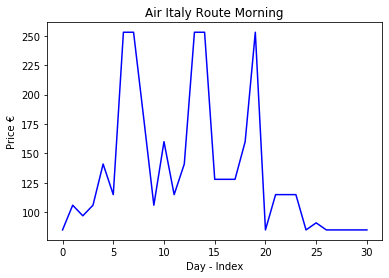

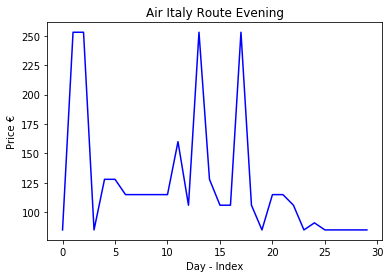

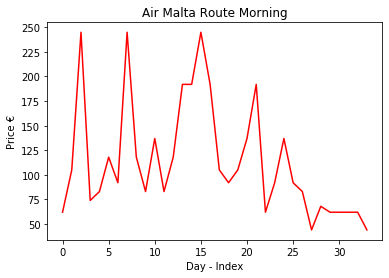

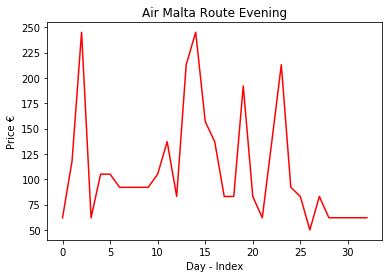

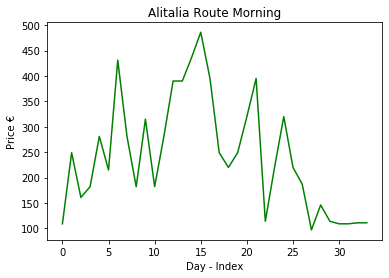

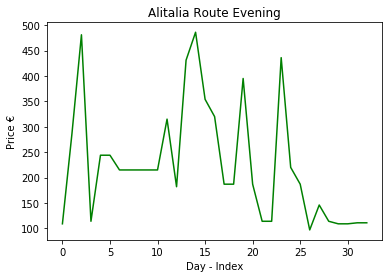

In [17]:

plt.plot(df_airitaly_morning.index.values, df_airitaly_morning['Price'], color="blue")
plt.title('Air Italy Route Morning')
plt.xlabel('Day - Index')
plt.ylabel('Price €')
plt.show()

plt.plot(df_airitaly_evening.index.values, df_airitaly_evening['Price'], color="blue")
plt.title('Air Italy Route Evening')
plt.xlabel('Day - Index')
plt.ylabel('Price €')
plt.show()

plt.plot(df_airmalta_morning.index.values, df_airmalta_morning['Price'], color="red")
plt.title('Air Malta Route Morning')
plt.xlabel('Day - Index')
plt.ylabel('Price €')
plt.show()

plt.plot(df_airmalta_evening.index.values, df_airmalta_evening['Price'], color="red")
plt.title('Air Malta Route Evening')
plt.xlabel('Day - Index')
plt.ylabel('Price €')
plt.show()

plt.plot(df_alitalia_morning.index.values, df_alitalia_morning['Price'], color="green")
plt.title('Alitalia Route Morning')
plt.xlabel('Day - Index')
plt.ylabel('Price €')
plt.show()

plt.plot(df_alitalia_evening.index.values, df_alitalia_evening['Price'], color="green")
plt.title('Alitalia Route Evening')
plt.xlabel('Day - Index')
plt.ylabel('Price €')
plt.show()



## Comparing price patterns 

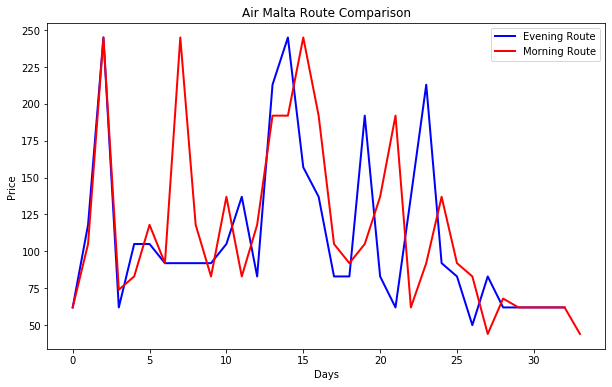

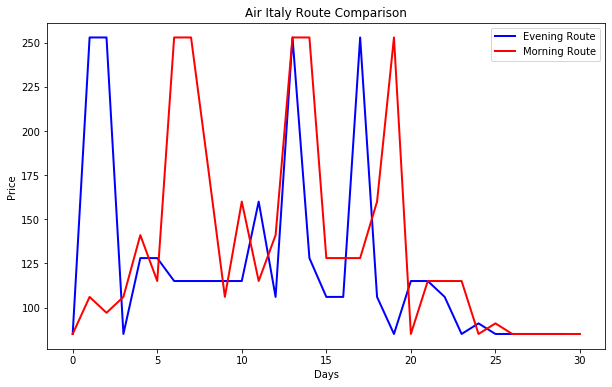

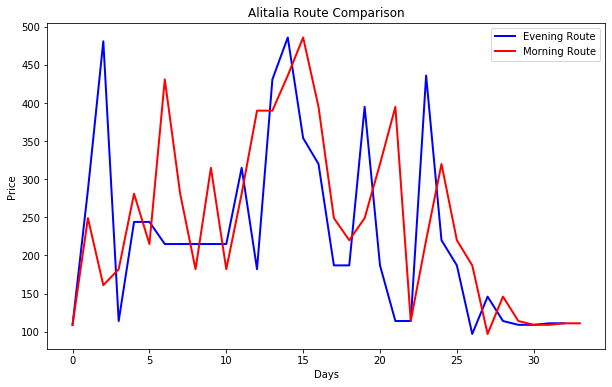

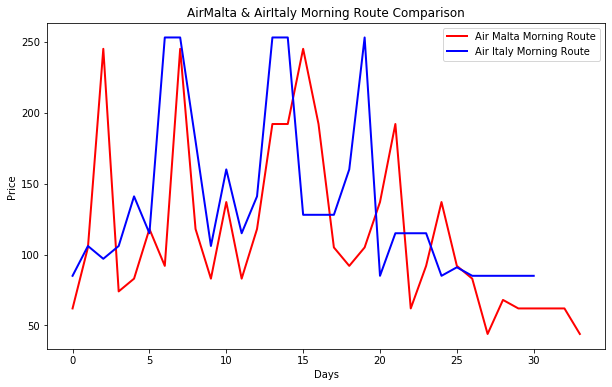

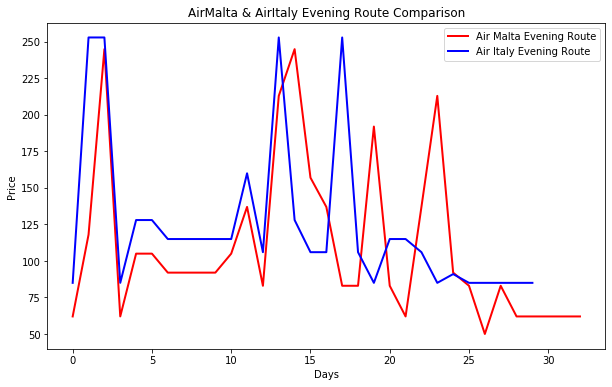

In [18]:
# multiple line plot
fig = plt.figure(figsize=(10,6))
plt.plot( df_airmalta_evening.index.values, df_airmalta_evening['Price'], marker='', markersize=12, color='blue', linewidth=2, label='Evening Route')
plt.plot( df_airmalta_morning.index.values, df_airmalta_morning['Price'], marker='', markersize=12, color='red', linewidth=2, label='Morning Route')
plt.title("Air Malta Route Comparison")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

fig = plt.figure(figsize=(10,6))
plt.plot( df_airitaly_evening.index.values, df_airitaly_evening['Price'], marker='', markersize=12, color='blue', linewidth=2, label='Evening Route')
plt.plot( df_airitaly_morning.index.values, df_airitaly_morning['Price'], marker='', markersize=12, color='red', linewidth=2, label='Morning Route')
plt.title("Air Italy Route Comparison")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

fig = plt.figure(figsize=(10,6))
plt.plot( df_alitalia_evening.index.values, df_alitalia_evening['Price'], marker='', markersize=12, color='blue', linewidth=2, label='Evening Route')
plt.plot( df_alitalia_morning.index.values, df_alitalia_morning['Price'], marker='', markersize=12, color='red', linewidth=2, label='Morning Route')
plt.title("Alitalia Route Comparison")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

fig = plt.figure(figsize=(10,6))
plt.plot( df_airmalta_morning.index.values, df_airmalta_morning['Price'], marker='', markersize=12, color='red', linewidth=2, label='Air Malta Morning Route')
plt.plot( df_airitaly_morning.index.values, df_airitaly_morning['Price'], marker='', markersize=12, color='blue', linewidth=2, label='Air Italy Morning Route')
plt.title("AirMalta & AirItaly Morning Route Comparison")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

fig = plt.figure(figsize=(10,6))
plt.plot( df_airmalta_evening.index.values, df_airmalta_evening['Price'], marker='', markersize=12, color='red', linewidth=2, label='Air Malta Evening Route')
plt.plot( df_airitaly_evening.index.values, df_airitaly_evening['Price'], marker='', markersize=12, color='blue', linewidth=2, label='Air Italy Evening Route')
plt.title("AirMalta & AirItaly Evening Route Comparison")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()




### From the plots above, it seems that most routes follow the same trends. It looks like they spike on the same days, around the days 2,7,13. It is also noticeable that the morning routes are more inclined to have price spikes. We can assume that the morning routes exhibit large price spikes every certain amount of days

In [19]:
#enter index number to view the date of price spikes
#df_airmalta_morning.iloc[2]   

In [20]:
output_notebook()


plot = figure(title='Scatter Plot - Flight Prices - Morning Routes',
             plot_height=500, plot_width=900,
             x_axis_label='Day Number', y_axis_label='Prices',
             x_minor_ticks=2, y_range=(0, 600),
             toolbar_location=None)

plot.circle( x = df_airitaly_morning.index.values  , y = df_airitaly_morning['Price'] , color = 'blue' , size = 5, alpha = 1.9, legend="Air Italy")
plot.circle( x = df_airmalta_morning.index.values  , y = df_airmalta_morning['Price'] , color = 'red' , size = 5, alpha = 1.9, legend="Air Malta")
plot.circle( x = df_alitalia_morning.index.values  , y = df_alitalia_morning['Price'] , color = 'green' , size = 5, alpha = 1.9, legend="Alitalia")

plot.line(x = df_airitaly_morning.index.values  , y = df_airitaly_morning['Price'] , color='blue')
plot.line(x = df_airmalta_morning.index.values  , y = df_airmalta_morning['Price'] , color='red')
plot.line(x = df_alitalia_morning.index.values  , y = df_alitalia_morning['Price'] , color='green')


show(plot)

Loading BokehJS ...

In [21]:
output_notebook()


plot = figure(title='Scatter Plot - Flight Prices - Evening Routes',
             plot_height=500, plot_width=900,
             x_axis_label='Day Number', y_axis_label='Prices',
             x_minor_ticks=2, y_range=(0, 600),
             toolbar_location=None)

plot.circle( x = df_airitaly_evening.index.values  , y = df_airitaly_evening['Price'] , color = 'blue' , size = 5, alpha = 1.9, legend="Air Italy")
plot.circle( x = df_airmalta_evening.index.values  , y = df_airmalta_evening['Price'] , color = 'red' , size = 5, alpha = 1.9, legend="Air Malta")
plot.circle( x = df_alitalia_evening.index.values  , y = df_alitalia_evening['Price'] , color = 'green' , size = 5, alpha = 1.9, legend="Alitalia")

plot.line(x = df_airitaly_evening.index.values  , y = df_airitaly_evening['Price'] , color='blue')
plot.line(x = df_airmalta_evening.index.values  , y = df_airmalta_evening['Price'] , color='red')
plot.line(x = df_alitalia_evening.index.values  , y = df_alitalia_evening['Price'] , color='green')


show(plot)

Loading BokehJS ...

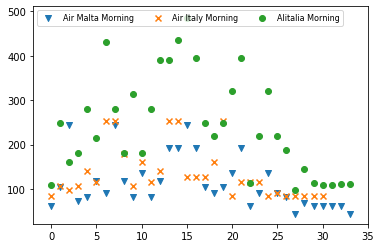

In [22]:
l0 = plt.scatter(df_airmalta_morning.index.values, df_airmalta_morning['Price'], marker = "v")
l1 = plt.scatter(df_airitaly_morning.index.values, df_airitaly_morning['Price'], marker = "x")
l2 = plt.scatter(df_alitalia_morning.index.values, df_alitalia_morning['Price'], marker = "o")

plt.legend((l0, l1, l2),
           ('Air Malta Morning', 'Air Italy Morning', 'Alitalia Morning'),
           scatterpoints=1,
           loc='upper left',
           ncol=3,
           fontsize=8)

plt.show()

## Plotly Scatter Plot

In [23]:
df.iplot(
    x='Date',
    y='Price',
    # Specify the category
    categories='Airline',
    xTitle='Departure Date',
    yTitle='Price',
    title='Scatter plot of all recorded flights')


## Descriptive Stats by Airline

Cheapest tickets

In [24]:
#lets check the 30 cheapest apartment prices
least30 = df.nsmallest(30, "Price") 
least30

,Airline,ArrivalTime,Date,DepartTime,Duration,Price
28,AirMalta,05:40,2020-01-05,05:00,40,44
79,AirMalta,05:40,2020-01-11,05:00,40,44
29,AirMalta,21:30,2020-01-05,20:50,40,50
134,AirMalta,05:40,2019-12-04,05:00,40,62
135,AirMalta,21:30,2019-12-04,20:50,40,62
1,AirMalta,21:30,2019-12-07,20:50,40,62
47,AirMalta,21:30,2019-12-31,20:50,40,62
46,AirMalta,05:40,2019-12-31,05:00,40,62
187,AirMalta,21:30,2020-01-07,20:50,40,62
186,AirMalta,05:40,2020-01-07,05:00,40,62


### Air Malta is the more affordable airline, Air Italy a close second. Cheapest ticket was 44 euros and it was in January

In [25]:
#Descriptive stats - min,max,mean,std
print('-------------------------------')
print('ALITALIA')
print('-------------------------------')
print(df_alitalia['Price'].describe())
print('-------------------------------')
print('AIRMALTA')
print('-------------------------------')
print(df_airmalta['Price'].describe())
print('-------------------------------')
print('AIRITALY')
print('-------------------------------')
print(df_airitaly['Price'].describe())

-------------------------------
ALITALIA
-------------------------------
count     67.000000
mean     234.656716
std      113.977477
min       97.000000
25%      114.000000
50%      215.000000
75%      315.000000
max      486.000000
Name: Price, dtype: float64
-------------------------------
AIRMALTA
-------------------------------
count     67.000000
mean     111.910448
std       56.480281
min       44.000000
25%       65.000000
50%       92.000000
75%      137.000000
max      245.000000
Name: Price, dtype: float64
-------------------------------
AIRITALY
-------------------------------
count     61.000000
mean     130.147541
std       55.900160
min       85.000000
25%       85.000000
50%      115.000000
75%      128.000000
max      253.000000
Name: Price, dtype: float64


## Box Plots

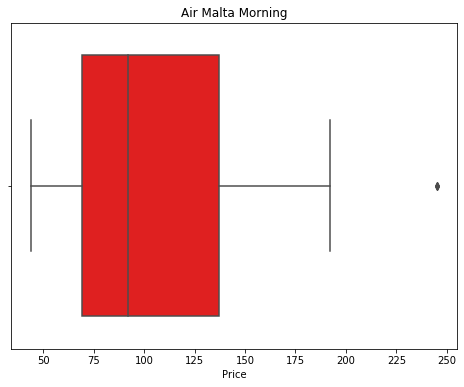

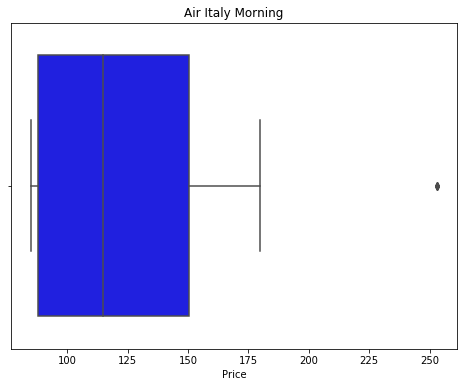

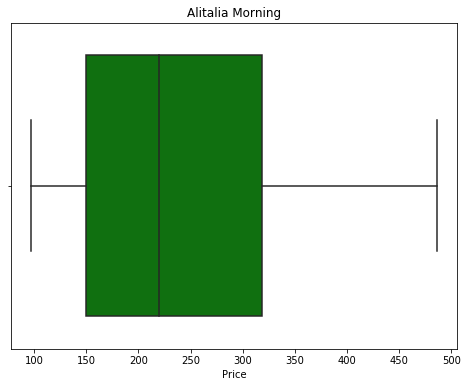

In [26]:
fig = plt.figure(figsize=(8,6))
sns.boxplot( y = df_airmalta_morning['Price'], orient="h", color = "red")
plt.title('Air Malta Morning')
plt.show()

fig = plt.figure(figsize=(8,6))
sns.boxplot( y = df_airitaly_morning['Price'], orient="h", color="blue")
plt.title('Air Italy Morning')
plt.show()

fig = plt.figure(figsize=(8,6))
sns.boxplot( y = df_alitalia_morning['Price'], orient="h", color ="green")
plt.title('Alitalia Morning')
plt.show()

#few outliers


As can be seen for the boxplots above, the median, min, max prices for AirMalta and AirItaly are similar.

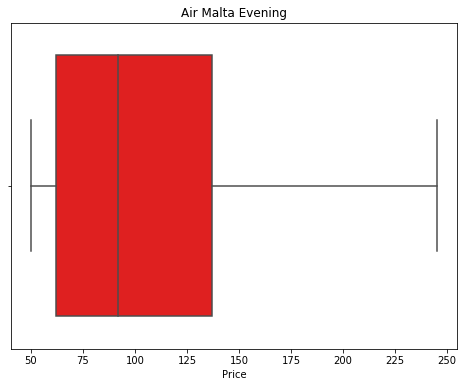

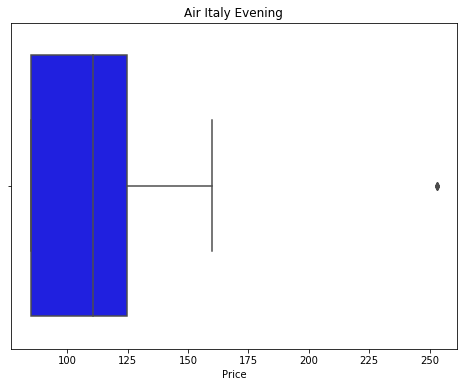

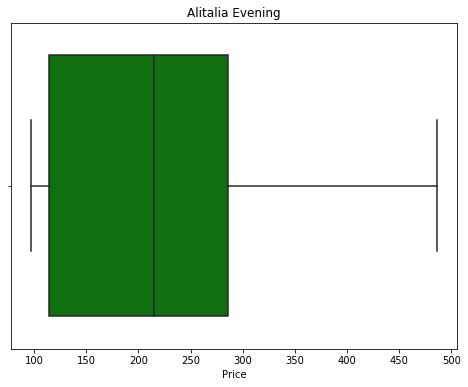

In [27]:
fig = plt.figure(figsize=(8,6))
sns.boxplot( y = df_airmalta_evening['Price'], orient="h", color = "red")
plt.title('Air Malta Evening')
plt.show()

fig = plt.figure(figsize=(8,6))
sns.boxplot( y = df_airitaly_evening['Price'], orient="h", color="blue")
plt.title('Air Italy Evening')
plt.show()

fig = plt.figure(figsize=(8,6))
sns.boxplot( y = df_alitalia_evening['Price'], orient="h", color ="green")
plt.title('Alitalia Evening')
plt.show()

An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. From our evening routes sample, it seems we have some outliers.

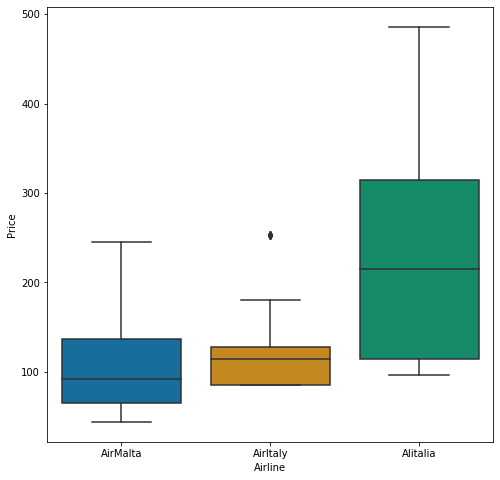

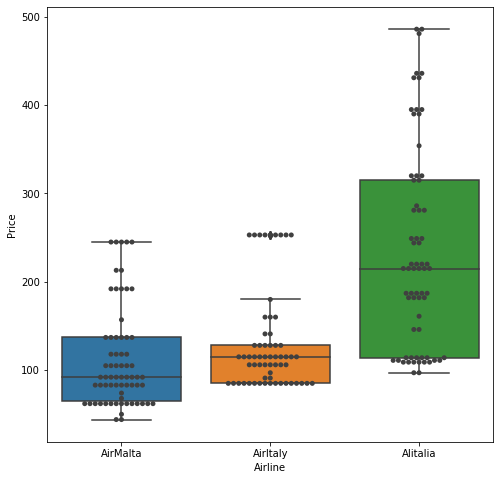

In [28]:
fig = plt.figure(figsize=(8,8))
sns.boxplot(y='Price', x='Airline', 
                 data=df, 
                 palette="colorblind")

fig = plt.figure(figsize=(8,8))
sns.boxplot(x="Airline", y="Price", data=df)
sns.swarmplot(x="Airline", y="Price", data=df, color=".25")


## Interactive Boxplots

In [29]:
df_airmalta.pivot(columns='Airline', values='Price').iplot(
        kind='box',
        yTitle='Price',
        title='Price Distribution - Air Malta - Morning & Evening ROutes')


In [30]:
df_airitaly.pivot(columns='Airline', values='Price').iplot(
        kind='box',
        yTitle='Price', color ='blue',
        title='Price Distribution - Air Italy - Morning & Evening Routes')


In [31]:
df_alitalia.pivot(columns='Airline', values='Price').iplot(
        kind='box',
        yTitle='Price', color ='green',
        title='Price Distribution - Alitalia - Morning & Evening Routes')

#### Only a few outliers in our data, its acceptable

## Descriptive Stats by Route

In [32]:
print('-------------------------------')
print('AIRMALTA MORNING')
print('-------------------------------')
print(df_airmalta_morning['Price'].describe())
print('-------------------------------')
print('AIRMALTA EVENING')
print('-------------------------------')
print(df_airmalta_evening['Price'].describe())

-------------------------------
AIRMALTA MORNING
-------------------------------
count     34.000000
mean     114.264706
std       58.572570
min       44.000000
25%       69.500000
50%       92.000000
75%      137.000000
max      245.000000
Name: Price, dtype: float64
-------------------------------
AIRMALTA EVENING
-------------------------------
count     33.000000
mean     109.484848
std       55.040963
min       50.000000
25%       62.000000
50%       92.000000
75%      137.000000
max      245.000000
Name: Price, dtype: float64


In [33]:
print('-------------------------------')
print('ALITALIA MORNING')
print('-------------------------------')
print(df_alitalia_morning['Price'].describe())
print('-------------------------------')
print('ALITALIA EVENING')
print('-------------------------------')
print(df_alitalia_evening['Price'].describe())

-------------------------------
ALITALIA MORNING
-------------------------------
count     34.000000
mean     242.852941
std      112.635947
min       97.000000
25%      149.750000
50%      220.000000
75%      318.750000
max      486.000000
Name: Price, dtype: float64
-------------------------------
ALITALIA EVENING
-------------------------------
count     33.000000
mean     226.212121
std      116.470693
min       97.000000
25%      114.000000
50%      215.000000
75%      286.000000
max      486.000000
Name: Price, dtype: float64


In [34]:
print('-------------------------------')
print('AIRITALY MORNING')
print('-------------------------------')
print(df_airitaly_morning['Price'].describe())
print('-------------------------------')
print('AIRITALY EVENING')
print('-------------------------------')
print(df_airitaly_evening['Price'].describe())

-------------------------------
AIRITALY MORNING
-------------------------------
count     31.000000
mean     135.225806
std       58.027413
min       85.000000
25%       88.000000
50%      115.000000
75%      150.500000
max      253.000000
Name: Price, dtype: float64
-------------------------------
AIRITALY EVENING
-------------------------------
count     30.000000
mean     124.900000
std       54.090824
min       85.000000
25%       85.000000
50%      110.500000
75%      124.750000
max      253.000000
Name: Price, dtype: float64


## Visualizing Descriptive Statistics

    Airline       Price
0  AirItaly  130.147541
1  AirMalta  111.910448
2  Alitalia  234.656716


Text(0.5, 1.0, 'Mean Price of Airlines across all routes')

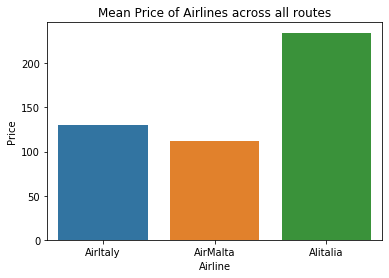

In [35]:
grouped = pd.DataFrame(df.groupby(['Airline'])['Price'].mean()).reset_index()
print(grouped)
sns.barplot(x="Airline", y="Price", data=grouped).set_title("Mean Price of Airlines across all routes")

    Airline  Price
0  AirItaly     85
1  AirMalta     44
2  Alitalia     97


Text(0.5, 1.0, 'Min Price of Airlines across all routes')

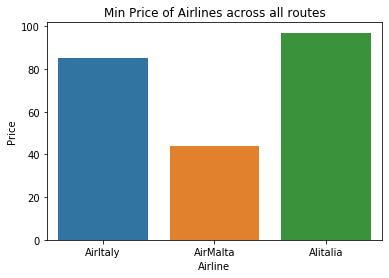

In [36]:
grouped2 = pd.DataFrame(df.groupby(['Airline'])['Price'].min()).reset_index()
print(grouped2)
sns.barplot(x="Airline", y="Price", data=grouped2).set_title("Min Price of Airlines across all routes")


    Airline  Price
0  AirItaly    253
1  AirMalta    245
2  Alitalia    486


Text(0.5, 1.0, 'Max Price of Airlines across all routes')

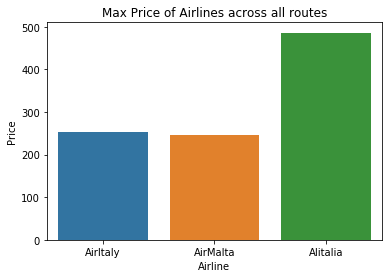

In [37]:
grouped3 = pd.DataFrame(df.groupby(['Airline'])['Price'].max()).reset_index()
print(grouped3)
sns.barplot(x="Airline", y="Price", data=grouped3).set_title("Max Price of Airlines across all routes") 

## Kernel Density Plots

These plots produce a smooth curve estimating the probability density function of a continuous
variable from a set of scores that likely contain some error. A kernel plot produces a smooth curved without assuming normality.

Probability density function (PDF) is a statistical expression that defines a probability distribution (the likelihood of an outcome) for a discrete random variable (e.g., a stock or ETF) as opposed to a continuous random variable. The difference between a discrete random variable is that you can identify an exact value of the variable. For instance, the value for the variable, e.g., a stock price, only goes two decimal points beyond the decimal (e.g. 52.55), while a continuous variable could have an infinite number of values (e.g. 52.5572389658…).

Morning Routes

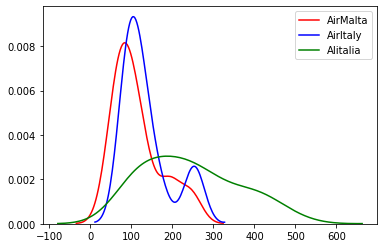

In [38]:
sns.kdeplot(df_airmalta_morning['Price'], color="red", label="AirMalta")
sns.kdeplot(df_airitaly_morning['Price'], color="blue", label="AirItaly")
sns.kdeplot(df_alitalia_morning['Price'], color="green", label="Alitalia")

Evening Routes

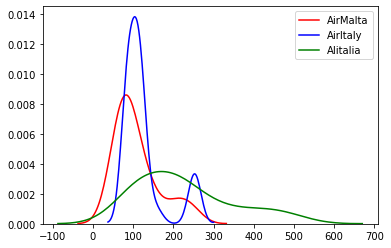

In [39]:
sns.kdeplot(df_airmalta_evening['Price'], color="red", label="AirMalta")
sns.kdeplot(df_airitaly_evening['Price'], color="blue", label="AirItaly")
sns.kdeplot(df_alitalia_evening['Price'], color="green", label="Alitalia")

The peaks potray at which price interval is there the highest density. Below is a density plot showing all routes

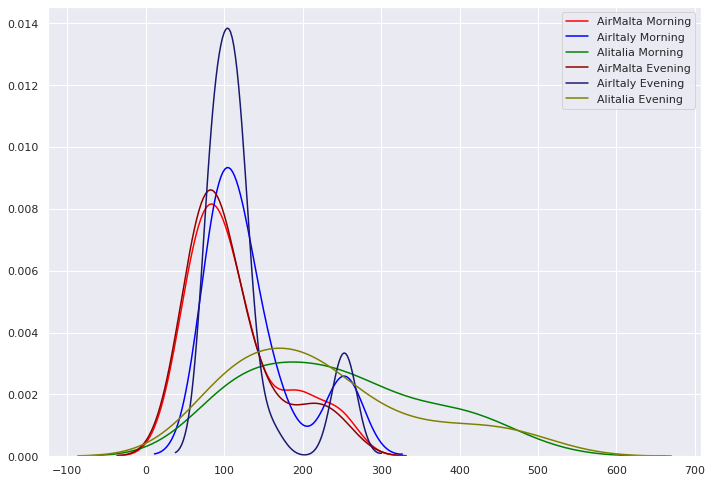

In [40]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.kdeplot(df_airmalta_morning['Price'], color="red", label="AirMalta Morning")
sns.kdeplot(df_airitaly_morning['Price'], color="blue", label="AirItaly Morning")
sns.kdeplot(df_alitalia_morning['Price'], color="green", label="Alitalia Morning")
sns.kdeplot(df_airmalta_evening['Price'], color="darkred", label="AirMalta Evening")
sns.kdeplot(df_airitaly_evening['Price'], color="midnightblue", label="AirItaly Evening")
sns.kdeplot(df_alitalia_evening['Price'], color="olive", label="Alitalia Evening")

## Histograms of Price Frequencies

In [41]:
df['Price'].iplot(kind='hist', xTitle='Price',
                  yTitle='Count', title='Price Distribution of all recorded tickets')

In [42]:
df_airmalta['Price'].iplot(kind='hist', xTitle='Price',
                  yTitle='Count', title='Price Distribution - Air Malta')

# Inferential Stats

## Normal Distribution Plots

Getting the sense of Price distribution across samples

It seems that that the evening and morning routes for Air Malta and Air Italy do not have a gaussian distribution, meaning it does not look 'normal' which is represented by a bell curve. Alitalia flights have a gaussian distribution

In [43]:
stat, p = stats.normaltest(df_airmalta_evening.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')
    
stat, p = stats.normaltest(df_airmalta_morning.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=10.121, p=0.006
Data does not look Gaussian (reject H0)
Statistics=6.595, p=0.037
Data does not look Gaussian (reject H0)


In [44]:
stat, p = stats.normaltest(df_airitaly_morning.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')
    
stat, p = stats.normaltest(df_airitaly_evening.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=8.223, p=0.016
Data does not look Gaussian (reject H0)
Statistics=16.704, p=0.000
Data does not look Gaussian (reject H0)


## Normally distirbuted data

In [45]:
stat, p = stats.normaltest(df_airitaly_morning.iloc[0:25].Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')
    
stat, p = stats.normaltest(df_airmalta_morning.iloc[0:25].Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=4.898, p=0.086
Data looks Gaussian (fail to reject H0)
Statistics=3.470, p=0.176
Data looks Gaussian (fail to reject H0)


In [46]:
stat, p = stats.normaltest(df_alitalia_evening.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')
    
stat, p = stats.normaltest(df_alitalia_morning.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=4.826, p=0.090
Data looks Gaussian (fail to reject H0)
Statistics=3.185, p=0.203
Data looks Gaussian (fail to reject H0)


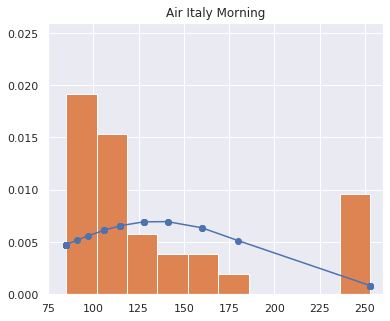

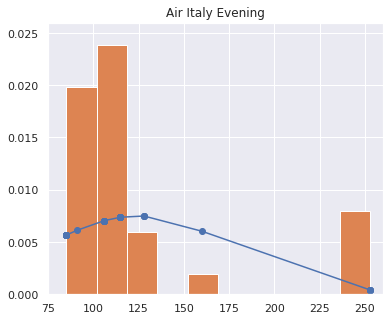

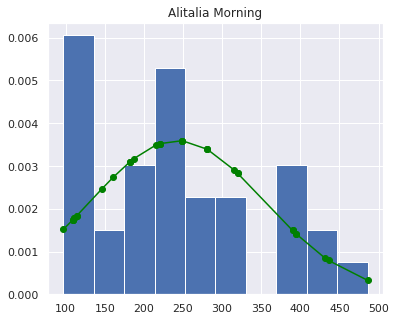

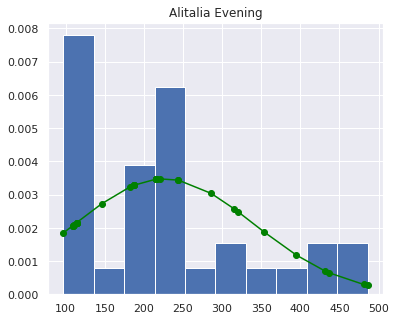

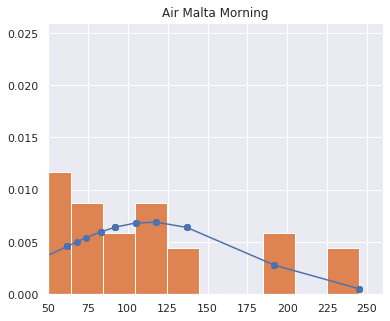

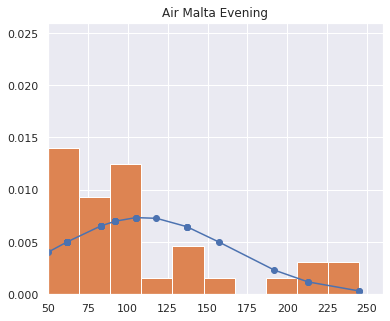

In [47]:
fig = plt.figure(figsize=(6,5))
h = df_airitaly_morning['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o')
pl.xlim (75, 260)
pl.ylim (0.000, 0.026)
pl.hist(h,normed=True)
pl.title('Air Italy Morning')
pl.show() 

fig = plt.figure(figsize=(6,5))
h = df_airitaly_evening['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o')
pl.xlim (75, 260)
pl.ylim (0.000, 0.026)
pl.hist(h,normed=True)
pl.title('Air Italy Evening')
pl.show() 

fig = plt.figure(figsize=(6,5))
h = df_alitalia_morning['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o',color="green")
pl.hist(h,normed=True) 
pl.title('Alitalia Morning')
pl.show() 

fig = plt.figure(figsize=(6,5))
h = df_alitalia_evening['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o',color="green")
pl.hist(h,normed=True) 
pl.title('Alitalia Evening')
pl.show() 

fig = plt.figure(figsize=(6,5))
h = df_airmalta_morning['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o')
pl.xlim (50, 260)
pl.ylim (0.000, 0.026)
pl.hist(h,normed=True)
pl.title('Air Malta Morning')
pl.show() 

fig = plt.figure(figsize=(6,5))
h = df_airmalta_evening['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o')
pl.xlim (50, 260)
pl.ylim (0.000, 0.026)
pl.hist(h,normed=True)
pl.title('Air Malta Evening')
pl.show() 




Null hypothesis :- In inferential statistics, the null hypothesis is a general statement or default position that there is no relationship between two measured phenomena, or no association among groups

Level of significance: Refers to the degree of significance in which we accept or reject the null-hypothesis. 100% accuracy is not possible for accepting or rejecting a hypothesis, so we therefore select a level of significance that is usually 5%.

# Correlation - Checking for association between variables

##  Pearson correlation 

Pearson correlation assumes that the data we are comparing is normally distributed. When that assumption is not true, the correlation value is reflecting the true association. We will calculate the correlation between routes with equal sample size (all our routes are not equal in sample size).

In [48]:
df_airmalta_evening.Date.count()

33

In [49]:
df_alitalia_evening.Date.count()

33

In [50]:
from scipy.stats.stats import pearsonr   
a = df_airmalta_evening['Price']
b = df_alitalia_evening['Price']
corr, p = pearsonr(a,b)
print(corr)
print(p)

0.9487889807337306
4.577493060346954e-17


The correlation value between Air Malta and Alitalia evening routes is very high. The P-value is the probability that you would have found the current result if the correlation coefficient were in fact zero (null hypothesis). If this probability is lower than the conventional 5% (P<0.05) the correlation coefficient is called statistically significant. So given our 'P' value is so low, there is an indication of a relationship between the routes being tested.

In [51]:
a = df_airitaly_morning.iloc[:20]
b = df_airmalta_evening.iloc[:20]
a = a['Price']
b = b['Price']
corr, p = pearsonr(a,b)
print(corr)
print(p)

0.3517385532193433
0.12830569499426614


In the case of the first airitaly morning route and airmalta evening route ( 21 days ), we fail to reject the null hypothesis

## Spearman Correlation

Spearman correlation does not assume that data is from a specific distribution, so it is a non-parametric correlation measure. Spearman correlation is also known as Spearman’s rank correlation as it computes correlation coefficient on rank values of the data. Similar to Pearson correlation, when a relationship is random or non-existent, then both correlation coefficients are nearly zero.


In [52]:
c = df_airmalta_evening['Price'].iloc[:14] # 1st 15 days
d = df_airitaly_evening['Price'].iloc[:14]
stats.spearmanr(c,d)

SpearmanrResult(correlation=0.9621023987294832, pvalue=3.941203232890752e-08)

In [53]:
stats.spearmanr(a,b)

SpearmanrResult(correlation=0.2120414360531146, pvalue=0.36945974356499856)

In the case of the first airitaly morning route and airmalta evening route ( 21 days ), we fail to reject the null hypothesis as well. But the correlation in the Spearman corr seems to be lower than Pearson corr

# Comparison of Means - Looking for difference between means of variables

## Independent Two Sample T-test

### This test assumes normality, so we took the first 25 rows of air malta and air italy morning routes for testing, considering they exhibit normality. It is also a rule of thumb to apply t-test on datasets with less than 30 samples

T- Test :- A t-test is a type of inferential statistic which is used to determine if there is a significant difference between the means of two groups which may be related in certain features. Z test is used when the sample size is large. 

The null hypothesis (H0) and alternative hypothesis (H1) of the Independent Samples t Test can be expressed in two different but equivalent ways:

H0: µ1 = µ2 ("the two population means are equal")
H1: µ1 ≠ µ2 ("the two population means are not equal")

In [53]:
# Try out different samples
a = df_airmalta_morning.iloc[0:25].Price
b = df_airitaly_morning.iloc[0:25].Price

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(a, b, equal_var=False)
print('-------------------------------------')
print(' AIR MALTA & AIR ITALY MORNING ROUTES ')
print('-------------------------------------')
print("ttest_ind:            t = %g  p = %g" % (t, p))

alpha = 0.05
if p > alpha:
    print('fail to reject H0')
else:
    print('reject H0')
    


-------------------------------------
 AIR MALTA & AIR ITALY MORNING ROUTES 
-------------------------------------
ttest_ind:            t = -0.896066  p = 0.37469
fail to reject H0


In [54]:
# Try out different samples
a = df_airmalta_evening.iloc[0:25].Price
b = df_airitaly_evening.iloc[0:25].Price

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(a, b, equal_var=False)
print('-------------------------------------')
print(' AIR MALTA & AIR ITALY EVENING ROUTES ')
print('-------------------------------------')
print("ttest_ind:            t = %g  p = %g" % (t, p))

alpha = 0.05
if p > alpha:
    print('fail to reject H0')
else:
    print('reject H0')
    


-------------------------------------
 AIR MALTA & AIR ITALY EVENING ROUTES 
-------------------------------------
ttest_ind:            t = -0.592284  p = 0.556441
fail to reject H0


The result is what we expect as both routes seem to follow similar trends as shown by the visualization carried out prior. Lets shuffle the list and see what results we get

In [55]:
#print(df_airmalta_morning.std())
#print(df_airitaly_morning.std())

## Shuffle data 

Given the data on both routes is similarly distributed, it would not matter to which label it belongs to. Lets shuffle the data, we are assuming:
- We know that these 2 routes are normally distributed
- They follow similar trends as potrayed by the visualization above
- The samples are independent from each other
- The standard deviation of both routes are similar

#### We will merge the 2 dataframes of the 2 routes we are testing together, and we will shuffle the order of the route column randomly and then we will apply the T-test

In [56]:
df_random_malta = df_airmalta_morning.sample(n=25) #taking 25 random samples
df_random_italy = df_airitaly_morning.sample(n=25)
malta_italy_test = pd.concat([df_random_italy, df_random_malta])
malta_italy_test = malta_italy_test.reset_index()
malta_italy_test = malta_italy_test.drop(['Airline','ArrivalTime','Date','DepartTime','Duration','index'],axis=1)
malta_italy_test


,level_0,Price,Route
0,2,97,IG9240
1,20,85,IG9240
2,0,85,IG9240
3,13,253,IG9240
4,23,115,IG9240
5,24,85,IG9240
6,7,253,IG9240
7,21,115,IG9240
8,17,128,IG9240
9,30,85,IG9240


In [57]:
difference_mean = df_random_malta.Price.mean() - df_random_italy.Price.mean() 
difference_mean # difference between both means

-25.439999999999998

In [58]:
difference_std = df_random_malta.Price.std() - df_random_italy.Price.std() 
difference_std

-0.3355993792554983

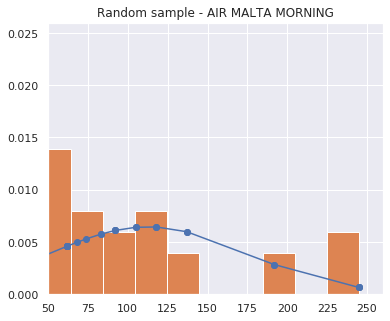

Statistics=5.941, p=0.051
Data looks Gaussian (fail to reject H0)


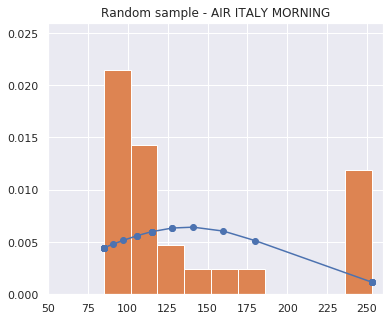

Statistics=5.941, p=0.051
Data looks Gaussian (fail to reject H0)


In [59]:
fig = plt.figure(figsize=(6,5))
h = df_random_malta['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o')
pl.xlim (50, 260)
pl.ylim (0.000, 0.026)
pl.hist(h,normed=True)
pl.title('Random sample - AIR MALTA MORNING')
pl.show() 

stat, p = stats.normaltest(df_random_malta.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

fig = plt.figure(figsize=(6,5))
h = df_random_italy['Price'].sort_values()
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  
pl.plot(h,fit,'-o')
pl.xlim (50, 260)
pl.ylim (0.000, 0.026)
pl.hist(h,normed=True)
pl.title('Random sample - AIR ITALY MORNING')
pl.show() 

stat, p = stats.normaltest(df_random_malta.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

In [60]:
fail_rej = 0
reject = 0

for i in range(1000):  # simulate 1000 times
    df4 = np.random.permutation(malta_italy_test['Price'].values) # shuffle price values
    malta_italy_test.drop(['Price'], axis=1) # drop unshuffled price values
    malta_italy_test['Price'] = df4 # insert unshuffled price value into original dataframe
    malta_italy_test # prices have been shuffled accordingly
    df_shuffle = malta_italy_test.groupby('Route')

    df_malta_shuffle = df_shuffle.get_group('KM640') 
    df_italy_shuffle = df_shuffle.get_group('IG9240')
    a = df_malta_shuffle['Price']
    b = df_italy_shuffle['Price']

# Use scipy.stats.ttest_ind.
    t, p = ttest_ind(a, b, equal_var=False)
    #print("ttest_ind:            t = %g  p = %g" % (t, p))
    
    alpha = 0.05
    if p > alpha:
        fail_rej += 1
    else:
        reject += 1
print('-----------------------------')
print("Fail to reject H0 count = %d" % fail_rej)
print("Reject H0 count =  %d" % reject)

-----------------------------
Fail to reject H0 count = 952
Reject H0 count =  48


For the most part, we fail to reject the null hypothesis

## One way ANOVA Test

We will use ordinary least squares regression with our data to minimize the squared error cost (OLS is the method used to find the simple linear regression of a set of data). The fitted model will be used with the anova_lm method to obtain a ANOVA table. We will assume that the data is normally distributed, if not normally distributed, there is a chance that our model will give us a false positive result since the anova model assumes normality similar to linear regression. Other methods are Kruskal-Wallis H-test or Welch’s ANOVA.
- Air Malta & Air Italy morning routes exhibit normality
- Alitalia Morning & Evening routes exhibit normality

In [61]:
mod = ols('Price ~ Route', data=malta_italy_test).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print('----------------------')
print('ANOVA table for Air Malta & Air Italy Morning Routes ')
print('----------------------')
print(aov_table)
print()

mod = ols('Price ~ Route', data=df_alitalia).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print('----------------------')
print('ANOVA table for Alitalia ')
print('----------------------')
print(aov_table)


----------------------
ANOVA table for Air Malta & Air Italy Morning Routes 
----------------------
             sum_sq    df         F    PR(>F)
Route        233.28   1.0  0.056146  0.813702
Residual  199433.04  48.0       NaN       NaN

----------------------
ANOVA table for Alitalia 
----------------------
                 sum_sq    df         F    PR(>F)
Route       4637.324620   1.0  0.353471  0.554219
Residual  852759.779857  65.0       NaN       NaN


Since the P-VALUE (PR>F) is greater than our error rate (>0.05), we can conclude that the relationships are not statistically significant (there is variance). We fail to reject the null hypothesis in this case

## Tests that are robust to non-normal distributed data

### We will apply tests to our non-normal distributed data using appropriate hypothesis tests

Mann-Whitney test; Mood’s median test; Kruskal-Wallis test instead of t-test

Mann-Whitney test is a nonparametric test of the null hypothesis that it is equally likely that a randomly selected value from one population will be less than or greater than a randomly selected value from a second population.

Assumptions:
- All the observations from both groups are independent of each other
- The responses are ordinal (one can say, of any two observations, which is the greater)
- Under the null hypothesis H0, the distributions of both populations are equal
- The alternative hypothesis H1 is that the distributions are not equal

In [62]:
stat, p = stats.normaltest(df_airmalta_evening.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')
    
stat, p = stats.normaltest(df_airitaly_evening.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=10.121, p=0.006
Data does not look Gaussian (reject H0)
Statistics=16.704, p=0.000
Data does not look Gaussian (reject H0)


In [63]:
df_random_malta_wh = df_airmalta_morning.sample(n=30) #taking 30 random samples
df_random_italy_wh = df_airitaly_morning.sample(n=30)

In [64]:
import scipy.stats as stats


stat, p = stats.mannwhitneyu(df_random_malta_wh.Price, df_random_italy_wh.Price)
print('P value:  %.3f '  %(p))
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

P value:  0.015 
Different distribution (reject H0)


Mood’s median test; Kruskal-Wallis test instead of anova test, kruskal wallis is an extension of matt whitney, it can extend to more than 2 groups. Lets compare all routes of AirMalta and AirItaly

In [65]:
from scipy.stats import kruskal

stat, p = kruskal(df_airmalta_evening.Price, df_airitaly_evening.Price, df_airitaly_morning.Price, df_airitaly_morning.Price )
print('P value:  %.3f' % ( p))
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

P value:  0.012
Different distributions (reject H0)
